In [10]:
# %matplotlib inline  # при желании включи magic
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

from joblib import dump
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

sns.set(style="whitegrid")
pd.set_option("display.max_columns", 200)
RANDOM_STATE = 42

os.makedirs("./data", exist_ok=True)
os.makedirs("./models", exist_ok=True)

Ethereum (2160, 10)


,sno,name,symbol,date,high,low,open,close,volume,marketcap
2157,2158,Ethereum,ETH,2021-07-04 23:59:59,2384.286857,2190.837703,2226.550382,2321.724112,1.878711e+10,2.706217e+11
2158,2159,Ethereum,ETH,2021-07-05 23:59:59,2321.922836,2163.041394,2321.922836,2198.582464,2.010379e+10,2.562978e+11
2159,2160,Ethereum,ETH,2021-07-06 23:59:59,2346.294874,2197.919385,2197.919385,2324.679449,2.089186e+10,2.710286e+11


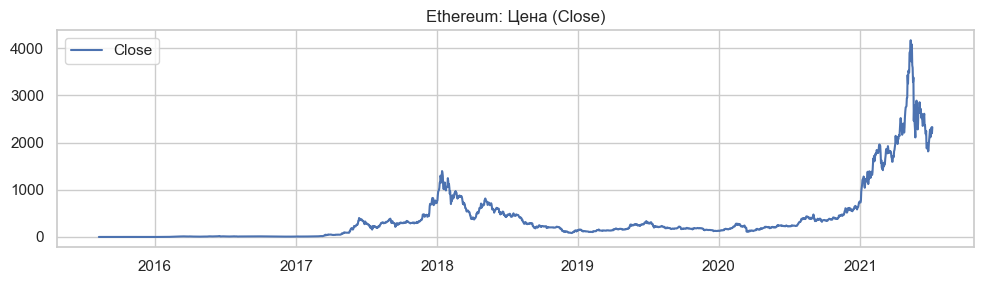

In [11]:
coin_name = "Ethereum"
coin_path = f"./data/coin_{coin_name}.csv"  # убедись, что файл так и называется

assert os.path.exists(coin_path), f"Файл не найден: {coin_path}"

df = pd.read_csv(coin_path)

# Приводим имена колонок и значения к нормальному виду
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
rename_map = {"market_cap": "marketcap", "market_capitalization": "marketcap"}
df = df.rename(columns=rename_map)

# Чистим числовые колонки от запятых/знаков, приводим к числам
for col in ["open","high","low","close","volume","marketcap"]:
    if col in df.columns:
        df[col] = (
            df[col].astype(str)
                  .str.replace(",", "", regex=False)
                  .str.replace("$", "", regex=False)
                  .str.replace(" ", "", regex=False)
        )
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Дата, сортировка
if "date" not in df.columns:
    if "timestamp" in df.columns:
        df["date"] = pd.to_datetime(df["timestamp"])
    else:
        raise ValueError("Не найден столбец 'date' в CSV.")

df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").drop_duplicates("date", keep="last").reset_index(drop=True)

# Базовые фильтры
df = df.dropna(subset=["close"])
df = df[df["close"] > 0].reset_index(drop=True)

print(coin_name, df.shape)
display(df.tail(3))

# График цены
plt.figure(figsize=(10,3))
plt.plot(df["date"], df["close"], label="Close")
plt.title(f"{coin_name}: Цена (Close)")
plt.legend()
plt.tight_layout()
plt.show()

Готовых наблюдений: 2138


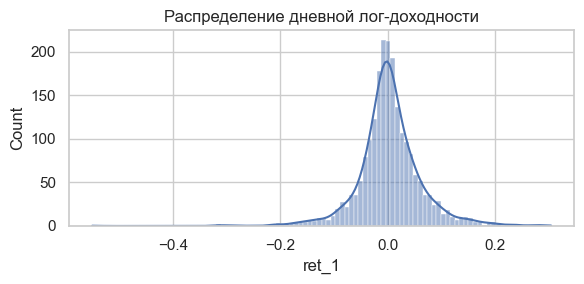

In [12]:
def rsi(series, window=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(alpha=1/window, adjust=False).mean()
    roll_down = down.ewm(alpha=1/window, adjust=False).mean()
    rs = roll_up / (roll_down + 1e-9)
    return 100 - 100 / (1 + rs)

def macd(series, span_fast=12, span_slow=26, span_signal=9):
    ema_fast = series.ewm(span=span_fast, adjust=False).mean()
    ema_slow = series.ewm(span=span_slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=span_signal, adjust=False).mean()
    hist = macd_line - signal_line
    return macd_line, signal_line, hist

def add_features(df):
    df = df.copy()
    df["log_close"] = np.log(df["close"].clip(lower=1e-9))
    df["ret_1"] = df["log_close"].diff(1)  # дневная лог-доходность

    # Лаги доходностей
    for l in [1, 2, 3, 5, 10, 20]:
        df[f"ret_lag_{l}"] = df["ret_1"].shift(l)

    # Скользящие средние/стд по доходностям
    for w in [5, 10, 20]:
        df[f"ret_mean_{w}"] = df["ret_1"].rolling(w).mean()
        df[f"ret_std_{w}"] = df["ret_1"].rolling(w).std()

    # Моментум по цене
    for w in [5, 10, 20]:
        df[f"mom_{w}"] = df["log_close"] - df["log_close"].shift(w)

    # Полосы Боллинджера (ширина, по цене)
    w = 20
    ma = df["close"].rolling(w).mean()
    sd = df["close"].rolling(w).std()
    df[f"bb_width_{w}"] = (2 * sd) / (ma + 1e-9)

    # RSI и MACD
    df["rsi_14"] = rsi(df["close"], 14)
    macd_line, signal_line, hist = macd(df["close"])
    df["macd"] = macd_line
    df["macd_signal"] = signal_line
    df["macd_hist"] = hist

    # Лог-объем (если есть)
    if "volume" in df.columns:
        df["log_vol"] = np.log1p(df["volume"].clip(lower=0))

    # Календарные признаки (циклические)
    dt = pd.to_datetime(df["date"])
    df["dow"] = dt.dt.dayofweek
    df["month"] = dt.dt.month
    df["dow_sin"] = np.sin(2*np.pi*df["dow"]/7)
    df["dow_cos"] = np.cos(2*np.pi*df["dow"]/7)
    df["mon_sin"] = np.sin(2*np.pi*df["month"]/12)
    df["mon_cos"] = np.cos(2*np.pi*df["month"]/12)

    # Таргет: доходность следующего дня
    df["y_next_ret"] = df["ret_1"].shift(-1)
    return df

df_feat = add_features(df)

planned_features = [
    "ret_lag_1","ret_lag_2","ret_lag_3","ret_lag_5","ret_lag_10","ret_lag_20",
    "ret_mean_5","ret_mean_10","ret_mean_20","ret_std_5","ret_std_10","ret_std_20",
    "mom_5","mom_10","mom_20",
    "rsi_14","macd","macd_signal","macd_hist","bb_width_20",
    "log_vol",
    "dow_sin","dow_cos","mon_sin","mon_cos"
]
feature_cols = [c for c in planned_features if c in df_feat.columns]

df_model = df_feat.dropna(subset=feature_cols + ["y_next_ret"]).copy()
print("Готовых наблюдений:", df_model.shape[0])

# Визуально: распределение дневной доходности
plt.figure(figsize=(6,3))
sns.histplot(df_model["ret_1"], bins=100, kde=True)
plt.title("Распределение дневной лог-доходности")
plt.tight_layout()
plt.show()

In [13]:
# Time split 80/20
split_idx = int(len(df_model) * 0.8)
train = df_model.iloc[:split_idx].copy()
test  = df_model.iloc[split_idx:].copy()

X_train, y_train = train[feature_cols], train["y_next_ret"]
X_test,  y_test  = test[feature_cols],  test["y_next_ret"]

# Цена в момент t (для восстановления цены t+1)
close_t_test = test["close"].astype(float)

# Модели
ridge = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0))
])

boost = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", HistGradientBoostingRegressor(
        random_state=RANDOM_STATE,
        max_depth=6, learning_rate=0.05, max_iter=500,
        early_stopping=True, validation_fraction=0.1
    ))
])

def evaluate_model(name, model, X_train, y_train, X_test, y_test, close_t_test):
    if model is not None:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    else:
        y_pred = np.zeros_like(y_test)  # наивный: доходность = 0

    # Метрики по доходностям
    rmse_ret = np.sqrt(mean_squared_error(y_test, y_pred))
    mae_ret  = mean_absolute_error(y_test, y_pred)
    r2_ret   = r2_score(y_test, y_pred)

    # Метрики по цене t+1
    price_true = close_t_test.values * np.exp(y_test.values)
    price_pred = close_t_test.values * np.exp(y_pred)
    rmse_price = np.sqrt(mean_squared_error(price_true, price_pred))
    mae_price  = mean_absolute_error(price_true, price_pred)
    mape_price = (np.abs(price_true - price_pred) / np.clip(np.abs(price_true), 1e-9, None)).mean() * 100

    # Точность направления
    dir_acc = (np.sign(y_test.values) == np.sign(y_pred)).mean()

    print(f"{name:>16} | Ret RMSE={rmse_ret:.5f} MAE={mae_ret:.5f} R2={r2_ret:.3f} | "
          f"Price RMSE={rmse_price:,.2f} MAE={mae_price:,.2f} MAPE={mape_price:.2f}% | DirAcc={dir_acc:.3f}")
    return y_pred, price_true, price_pred

print("\nОценка моделей:")
_yp_naive, p_true, p_pred_naive = evaluate_model("Naive(0-ret)", None, X_train, y_train, X_test, y_test, close_t_test)
y_pred_ridge, p_true, p_pred_ridge = evaluate_model("Ridge", ridge, X_train, y_train, X_test, y_test, close_t_test)
y_pred_boost, p_true, p_pred_boost = evaluate_model("HistGBR", boost, X_train, y_train, X_test, y_test, close_t_test)


Оценка моделей:
    Naive(0-ret) | Ret RMSE=0.05337 MAE=0.03819 R2=-0.011 | Price RMSE=101.90 MAE=51.77 MAPE=3.82% | DirAcc=0.000
           Ridge | Ret RMSE=0.05458 MAE=0.03892 R2=-0.058 | Price RMSE=103.06 MAE=52.68 MAPE=3.87% | DirAcc=0.495
         HistGBR | Ret RMSE=0.05317 MAE=0.03832 R2=-0.003 | Price RMSE=101.12 MAE=51.97 MAPE=3.84% | DirAcc=0.521


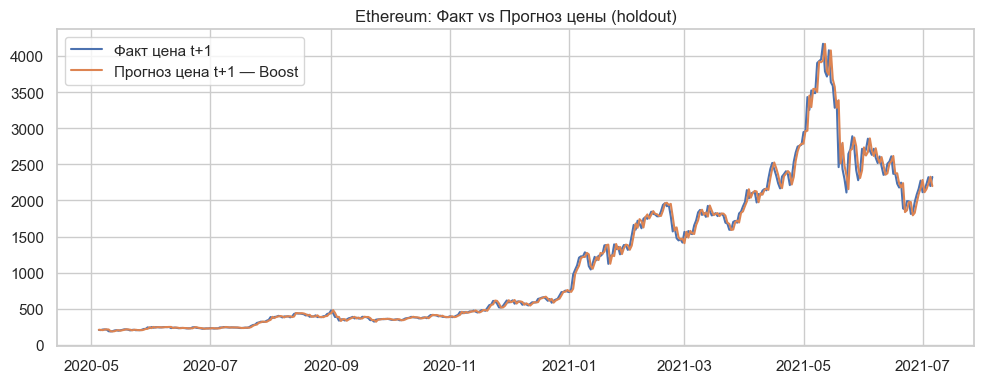

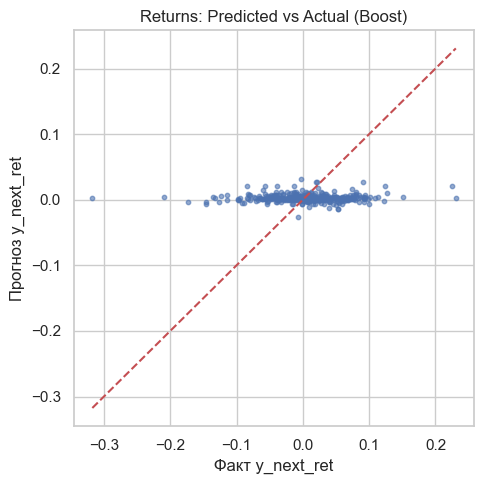

In [14]:
# Цена: факт vs прогноз (бустинг)
plt.figure(figsize=(10,4))
plt.plot(test["date"], p_true, label="Факт цена t+1")
plt.plot(test["date"], p_pred_boost, label="Прогноз цена t+1 — Boost")
plt.title(f"{coin_name}: Факт vs Прогноз цены (holdout)")
plt.legend()
plt.tight_layout()
plt.show()

# Scatter: доходности факт vs прогноз (бустинг)
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred_boost, s=10, alpha=0.6)
mn, mx = float(min(y_test.min(), y_pred_boost.min())), float(max(y_test.max(), y_pred_boost.max()))
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel("Факт y_next_ret")
plt.ylabel("Прогноз y_next_ret")
plt.title("Returns: Predicted vs Actual (Boost)")
plt.tight_layout()
plt.show()

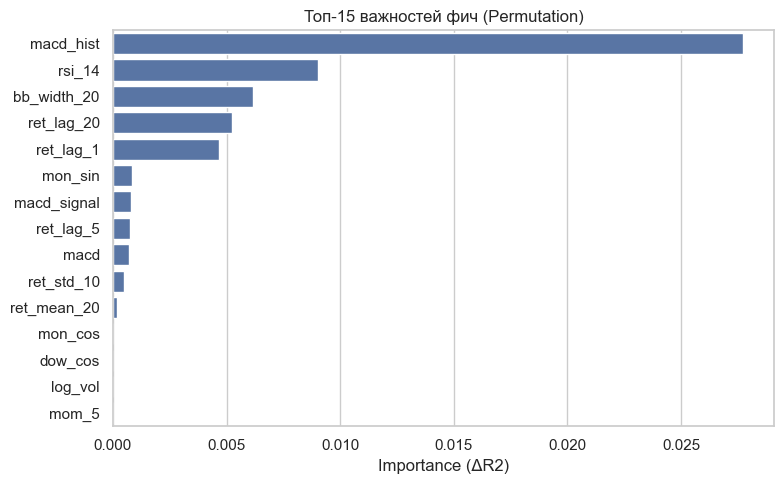

In [15]:
boost.fit(X_train, y_train)
r = permutation_importance(boost, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE, scoring="r2")
imp = pd.Series(r.importances_mean, index=feature_cols).sort_values(ascending=False).head(15)

plt.figure(figsize=(8,5))
sns.barplot(x=imp.values, y=imp.index, color="#4C72B0")
plt.title("Топ-15 важностей фич (Permutation)")
plt.xlabel("Importance (ΔR2)")
plt.ylabel("")
plt.tight_layout()
plt.show()

In [16]:
def prepare_features_for_latest(df_raw, feature_cols):
    df_feat = add_features(df_raw)
    row = df_feat.dropna(subset=feature_cols).iloc[-1:]
    X_row = row[feature_cols]
    close_t = float(row["close"].iloc[0])
    date_t  = pd.to_datetime(row["date"].iloc[0])
    return X_row, close_t, date_t

X_last, close_last, date_last = prepare_features_for_latest(df, feature_cols)
pred_next_ret = boost.predict(X_last)[0]
pred_next_price = close_last * np.exp(pred_next_ret)

print(f"Последняя дата в данных: {date_last.date()}, Close={close_last:,.2f}")
print(f"Прогноз цены на следующий день: {pred_next_price:,.2f}")

Последняя дата в данных: 2021-07-06, Close=2,324.68
Прогноз цены на следующий день: 2,330.95


In [17]:
model_path = f"./models/{coin_name.lower()}_return_model_hgbr.joblib"
dump({"coin": coin_name, "feature_cols": feature_cols, "pipeline": boost}, model_path)
print("Модель сохранена в:", model_path)

Модель сохранена в: ./models/ethereum_return_model_hgbr.joblib
